# Generate all relevant data for mutualisms in COMETS

Set up the necessary environment.

In [1]:
#are you connected to the campus vpn full tunneling? if not, forget about it
import cobra
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cometspy as c
import os

In [2]:
E_WT_infected = cobra.io.read_sbml_model("../models/iJO1366_plasmid_phage.xml")
S0 = cobra.io.read_sbml_model("../models/STM_v1_0_S0.xml")
M0 = cobra.io.read_sbml_model("../models/jmc_AM1_KO_renamed.xml")

export_path_E = "../fba-data/figure-1/comets/"
export_path_co = "../fba-data/supp-figure-1/"

In [3]:
E0_infected = E_WT_infected.copy()
E0_infected.genes.b3939.knock_out()

### Get viral bound by condition from get-lower-bounds-virus.ipynb

In [4]:
phage_bound = 1.039592758
minimum_bound = 0.000
maximum_bound_phage = phage_bound
step_size_phage = 0.1

plasmid_bound = 1.0187592594
minimum_bound = 0.000
maximum_bound_plasmid = plasmid_bound
step_size_plasmid = 0.1

phageplasmid_bound = 0.12118787128
minimum_bound = 0.000
maximum_bound_phageplasmid = phageplasmid_bound
step_size_phageplasmid = 0.01

plasmid_threshold = 0.4

## Lag time implementation

In [45]:
# number of lag cycles
max_cycles = 200
lag_length = 50

# run initial lag
E0_infected.reactions.plasmid_F.lower_bound = 0.0
E0_infected.reactions.phage_M13.lower_bound = 0.0
E0_infected.reactions.get_by_id("BIOMASS_Ec_iJO1366_core_53p95M").upper_bound = 0

E_infected = c.model(E0_infected)
S = c.model(S0)
M = c.model(M0)
E_infected.open_exchanges()
S.open_exchanges()
M.open_exchanges()

E_infected.initial_pop = [0, 0, 1.e-8]
S.initial_pop = [0, 0, 1.e-8]
M.initial_pop = [0, 0, 1.e-8]
E_infected.obj_style = "MAXIMIZE_OBJECTIVE_FLUX" #this is for pFBA - MAX_OBJECTIVE_FLUX for fba
S.obj_style =  "MAXIMIZE_OBJECTIVE_FLUX"
M.obj_style =  "MAXIMIZE_OBJECTIVE_FLUX"

l = c.layout([E_infected,S,M])
base_nutrients = ["ca2_e", "cl_e", "cobalt2_e", "cu2_e","fe2_e", "fe3_e", "k_e","mg2_e",
          "mn2_e", "mobd_e", "ni2_e", "o2_e", "pi_e", "so4_e", "zn2_e"]
for nutrient in base_nutrients:
    l.set_specific_metabolite(nutrient, 1000)
l.set_specific_metabolite("lcts_e", 0.000278)
l.set_specific_metabolite("mea_e", 10)
l.set_specific_metabolite("met__L_e", 0.000000015)

p = c.params()
p.set_param("defaultKm", 0.00001) # M 
p.set_param("defaultVmax", 10) #mmol/gDw/hr
p.set_param("maxCycles", lag_length)
p.set_param("timeStep", 1)
p.set_param("writeMediaLog", True)
p.set_param("MediaLogRate", 1)
p.set_param("writeFluxLog", True)
p.set_param("FluxLogRate", 1)

sim = c.comets(l, p)
sim.run()

lag_biomass = sim.total_biomass

# run the rest of the simulation
lag_media = sim.media
final_cycle_df = lag_media[lag_media['cycle'] == lag_length]

E0_infected.reactions.plasmid_F.lower_bound = 0.0
E0_infected.reactions.phage_M13.lower_bound = 0.0
E0_infected.reactions.get_by_id("BIOMASS_Ec_iJO1366_core_53p95M").upper_bound = 1000 # allow biomass generation again

E_infected = c.model(E0_infected)
S = c.model(S0)
M = c.model(M0)
E_infected.open_exchanges()
S.open_exchanges()
M.open_exchanges()

E_infected.initial_pop = [0, 0, sim.total_biomass.loc[sim.total_biomass['cycle'] == lag_length, 'iJO1366'].values[0]]
S.initial_pop = [0, 0, sim.total_biomass.loc[sim.total_biomass['cycle'] == lag_length, 'STM_v1_0'].values[0]]
M.initial_pop = [0, 0, sim.total_biomass.loc[sim.total_biomass['cycle'] == lag_length, 'Mrubrum_AM1_hprKO'].values[0]]
E_infected.obj_style = "MAXIMIZE_OBJECTIVE_FLUX" #this is for pFBA - MAX_OBJECTIVE_FLUX for fba
S.obj_style =  "MAXIMIZE_OBJECTIVE_FLUX"
M.obj_style =  "MAXIMIZE_OBJECTIVE_FLUX"

l = c.layout([E_infected,S,M])
for _, row in final_cycle_df.iterrows():
    metabolite = row['metabolite']
    conc = row['conc_mmol']
    l.set_specific_metabolite(metabolite, conc)

p = c.params()
p.set_param("defaultKm", 0.00001) # M 
p.set_param("defaultVmax", 10) #mmol/gDw/hr
p.set_param("maxCycles", max_cycles - lag_length)
p.set_param("timeStep", 1)
p.set_param("writeMediaLog", True)
p.set_param("MediaLogRate", 1)
p.set_param("writeFluxLog", True)
p.set_param("FluxLogRate", 1)

sim = c.comets(l, p)
sim.run()


Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!


In [55]:
# number of lag cycles
max_cycles = 200
lag_length = 50

# run initial lag
E0_infected.reactions.plasmid_F.lower_bound = 0.0
E0_infected.reactions.phage_M13.lower_bound = 0.0
E0_infected.reactions.get_by_id("BIOMASS_Ec_iJO1366_core_53p95M").upper_bound = 0

E_infected = c.model(E0_infected)
M = c.model(M0)
E_infected.open_exchanges()
M.open_exchanges()

E_infected.initial_pop = [0, 0, 1.e-8]
M.initial_pop = [0, 0, 1.e-8]
E_infected.obj_style = "MAXIMIZE_OBJECTIVE_FLUX" #this is for pFBA - MAX_OBJECTIVE_FLUX for fba
M.obj_style =  "MAXIMIZE_OBJECTIVE_FLUX"

l = c.layout([E_infected,M])
base_nutrients = ["ca2_e", "cl_e", "cobalt2_e", "cu2_e","fe2_e", "fe3_e", "k_e","mg2_e",
          "mn2_e", "mobd_e", "ni2_e", "o2_e", "pi_e", "so4_e", "zn2_e"]
for nutrient in base_nutrients:
    l.set_specific_metabolite(nutrient, 1000)
l.set_specific_metabolite("lcts_e", 0.000278)
l.set_specific_metabolite("mea_e", 10)
l.set_specific_metabolite("met__L_e", 10)

p = c.params()
p.set_param("defaultKm", 0.00001) # M 
p.set_param("defaultVmax", 10) #mmol/gDw/hr
p.set_param("maxCycles", lag_length)
p.set_param("timeStep", 1)
p.set_param("writeMediaLog", True)
p.set_param("MediaLogRate", 1)
p.set_param("writeFluxLog", True)
p.set_param("FluxLogRate", 1)

sim = c.comets(l, p)
sim.run()

lag_biomass = sim.total_biomass

# run the rest of the simulation
lag_media = sim.media
final_cycle_df = lag_media[lag_media['cycle'] == lag_length]

E0_infected.reactions.plasmid_F.lower_bound = 0.0
E0_infected.reactions.phage_M13.lower_bound = 0.0
E0_infected.reactions.get_by_id("BIOMASS_Ec_iJO1366_core_53p95M").upper_bound = 1000 # allow biomass generation again

E_infected = c.model(E0_infected)
M = c.model(M0)
E_infected.open_exchanges()
M.open_exchanges()

E_infected.initial_pop = [0, 0, sim.total_biomass.loc[sim.total_biomass['cycle'] == lag_length, 'iJO1366'].values[0]]
M.initial_pop = [0, 0, sim.total_biomass.loc[sim.total_biomass['cycle'] == lag_length, 'Mrubrum_AM1_hprKO'].values[0]]
E_infected.obj_style = "MAXIMIZE_OBJECTIVE_FLUX" #this is for pFBA - MAX_OBJECTIVE_FLUX for fba
M.obj_style =  "MAXIMIZE_OBJECTIVE_FLUX"

l = c.layout([E_infected,M])
for _, row in final_cycle_df.iterrows():
    metabolite = row['metabolite']
    conc = row['conc_mmol']
    l.set_specific_metabolite(metabolite, conc)

p = c.params()
p.set_param("defaultKm", 0.00001) # M 
p.set_param("defaultVmax", 10) #mmol/gDw/hr
p.set_param("maxCycles", max_cycles - lag_length)
p.set_param("timeStep", 1)
p.set_param("writeMediaLog", True)
p.set_param("MediaLogRate", 1)
p.set_param("writeFluxLog", True)
p.set_param("FluxLogRate", 1)

sim = c.comets(l, p)
sim.run()


Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!


In [65]:
# number of lag cycles
max_cycles = 200
lag_length = 50

# run initial lag
E0_infected.reactions.plasmid_F.lower_bound = 0.0
E0_infected.reactions.phage_M13.lower_bound = 0.0
E0_infected.reactions.get_by_id("BIOMASS_Ec_iJO1366_core_53p95M").upper_bound = 0

E_infected = c.model(E0_infected)
S = c.model(S0)
E_infected.open_exchanges()
S.open_exchanges()

E_infected.initial_pop = [0, 0, 1.e-8]
S.initial_pop = [0, 0, 1.e-8]
E_infected.obj_style = "MAXIMIZE_OBJECTIVE_FLUX" #this is for pFBA - MAX_OBJECTIVE_FLUX for fba
S.obj_style =  "MAXIMIZE_OBJECTIVE_FLUX"

l = c.layout([E_infected,S])
base_nutrients = ["ca2_e", "cl_e", "cobalt2_e", "cu2_e","fe2_e", "fe3_e", "k_e","mg2_e",
          "mn2_e", "mobd_e", "ni2_e", "o2_e", "pi_e", "so4_e", "zn2_e", "nh4_e"]
for nutrient in base_nutrients:
    l.set_specific_metabolite(nutrient, 1000)
l.set_specific_metabolite("lcts_e", 0.000278)
l.set_specific_metabolite("met__L_e", 0.000000015)

p = c.params()
p.set_param("defaultKm", 0.00001) # M 
p.set_param("defaultVmax", 10) #mmol/gDw/hr
p.set_param("maxCycles", lag_length)
p.set_param("timeStep", 1)
p.set_param("writeMediaLog", True)
p.set_param("MediaLogRate", 1)
p.set_param("writeFluxLog", True)
p.set_param("FluxLogRate", 1)

sim = c.comets(l, p)
sim.run()

lag_biomass = sim.total_biomass

# run the rest of the simulation
lag_media = sim.media
final_cycle_df = lag_media[lag_media['cycle'] == lag_length]

E0_infected.reactions.plasmid_F.lower_bound = 0.0
E0_infected.reactions.phage_M13.lower_bound = 0.0
E0_infected.reactions.get_by_id("BIOMASS_Ec_iJO1366_core_53p95M").upper_bound = 1000 # allow biomass generation again

E_infected = c.model(E0_infected)
S = c.model(S0)
E_infected.open_exchanges()
S.open_exchanges()

E_infected.initial_pop = [0, 0, sim.total_biomass.loc[sim.total_biomass['cycle'] == lag_length, 'iJO1366'].values[0]]
S.initial_pop = [0, 0, sim.total_biomass.loc[sim.total_biomass['cycle'] == lag_length, 'STM_v1_0'].values[0]]
E_infected.obj_style = "MAXIMIZE_OBJECTIVE_FLUX" #this is for pFBA - MAX_OBJECTIVE_FLUX for fba
S.obj_style =  "MAXIMIZE_OBJECTIVE_FLUX"

l = c.layout([E_infected,S])
for _, row in final_cycle_df.iterrows():
    metabolite = row['metabolite']
    conc = row['conc_mmol']
    l.set_specific_metabolite(metabolite, conc)

p = c.params()
p.set_param("defaultKm", 0.00001) # M 
p.set_param("defaultVmax", 10) #mmol/gDw/hr
p.set_param("maxCycles", max_cycles - lag_length)
p.set_param("timeStep", 1)
p.set_param("writeMediaLog", True)
p.set_param("MediaLogRate", 1)
p.set_param("writeFluxLog", True)
p.set_param("FluxLogRate", 1)

sim = c.comets(l, p)
sim.run()


Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!


In [70]:
# number of lag cycles
max_cycles = 200
lag_length = 50

# run initial lag
E0_infected.reactions.plasmid_F.lower_bound = 0.0
E0_infected.reactions.phage_M13.lower_bound = 0.0
E0_infected.reactions.get_by_id("BIOMASS_Ec_iJO1366_core_53p95M").upper_bound = 0

E_infected = c.model(E0_infected)
E_infected.open_exchanges()

E_infected.initial_pop = [0, 0, 1.e-8]
E_infected.obj_style = "MAXIMIZE_OBJECTIVE_FLUX"

test_tube = c.layout()
test_tube.add_model(E_infected)

base_nutrients = ['ca2_e', 'cl_e', 'cobalt2_e', 'cu2_e', 'fe2_e', 'fe3_e', 'h_e', 'k_e', 'h2o_e', 'mg2_e',
             'mn2_e', 'mobd_e', 'na1_e', 'ni2_e', 'nh4_e', 'o2_e', 'pi_e', 'so4_e', 'zn2_e']
for nutrient in base_nutrients:
    test_tube.set_specific_metabolite(nutrient, 1000)
    test_tube.set_specific_static(nutrient, 1000)
test_tube.set_specific_metabolite("lcts_e", 0.000278)
test_tube.set_specific_metabolite('met__L_e', 10)

sim_params = c.params()
sim_params.set_param("defaultKm", 0.00001) # M 
sim_params.set_param("defaultVmax", 10) #mmol/gDw/hr
sim_params.set_param("maxCycles", lag_length)
sim_params.set_param("timeStep", 1)
sim_params.set_param("writeMediaLog", True)
sim_params.set_param("MediaLogRate", 1)
sim_params.set_param("writeFluxLog", True)
sim_params.set_param("FluxLogRate", 1)

comp_assay = c.comets(test_tube, sim_params)
comp_assay.run()

# run the rest of the simulation
lag_media = comp_assay.media
final_cycle_df = lag_media[lag_media['cycle'] == lag_length]

E0_infected.reactions.plasmid_F.lower_bound = 0.0
E0_infected.reactions.phage_M13.lower_bound = 0.0
E0_infected.reactions.get_by_id("BIOMASS_Ec_iJO1366_core_53p95M").upper_bound = 1000

E_infected = c.model(E0_infected)
E_infected.open_exchanges()

E_infected.initial_pop = [0, 0, comp_assay.total_biomass.loc[comp_assay.total_biomass['cycle'] == lag_length, 'iJO1366'].values[0]]
E_infected.obj_style = "MAXIMIZE_OBJECTIVE_FLUX"

test_tube = c.layout()
test_tube.add_model(E_infected)

for _, row in final_cycle_df.iterrows():
    metabolite = row['metabolite']
    conc = row['conc_mmol']
    test_tube.set_specific_metabolite(metabolite, conc)

sim_params = c.params()
sim_params.set_param("defaultKm", 0.00001) # M 
sim_params.set_param("defaultVmax", 10) #mmol/gDw/hr
sim_params.set_param("maxCycles", max_cycles - lag_length)
sim_params.set_param("timeStep", 1)
sim_params.set_param("writeMediaLog", True)
sim_params.set_param("MediaLogRate", 1)
sim_params.set_param("writeFluxLog", True)
sim_params.set_param("FluxLogRate", 1)

comp_assay = c.comets(test_tube, sim_params)
comp_assay.run()

building empty layout model
models will need to be added with layout.add_model()

Running COMETS simulation ...

Debug Here ...
Done!
building empty layout model
models will need to be added with layout.add_model()

Running COMETS simulation ...

Debug Here ...
Done!


In [29]:
E0_infected.reactions.plasmid_F.lower_bound = 0.1
E0_infected.reactions.phage_M13.lower_bound = 0.06
E0_infected.objective = E0_infected.reactions.get_by_id("BIOMASS_Ec_iJO1366_core_53p95M")

E_infected = c.model(E0_infected)
E_infected.open_exchanges()

E_infected.initial_pop = [0, 0, 1.e-8]
E_infected.obj_style = "MAXIMIZE_OBJECTIVE_FLUX"

test_tube = c.layout()
test_tube.add_model(E_infected)

base_nutrients = ['ca2_e', 'cl_e', 'cobalt2_e', 'cu2_e', 'fe2_e', 'fe3_e', 'h_e', 'k_e', 'h2o_e', 'mg2_e',
             'mn2_e', 'mobd_e', 'na1_e', 'ni2_e', 'nh4_e', 'o2_e', 'pi_e', 'so4_e', 'zn2_e']
for nutrient in base_nutrients:
    test_tube.set_specific_metabolite(nutrient, 1000)
    test_tube.set_specific_static(nutrient, 1000)
test_tube.set_specific_metabolite("lac__D_e", 0.000278)
test_tube.set_specific_metabolite('met__L_e', 10)

sim_params = c.params()
sim_params.set_param("defaultKm", 0.00001) # M 
sim_params.set_param("defaultVmax", 10) #mmol/gDw/hr
sim_params.set_param("maxCycles", 200)
sim_params.set_param("timeStep", 1)
sim_params.set_param("writeMediaLog", True)
sim_params.set_param("MediaLogRate", 1)
sim_params.set_param("writeFluxLog", True)
sim_params.set_param("FluxLogRate", 1)

comp_assay = c.comets(test_tube, sim_params)
comp_assay.run()

building empty layout model
models will need to be added with layout.add_model()

Running COMETS simulation ...

Debug Here ...
Done!


<Axes: xlabel='cycle'>

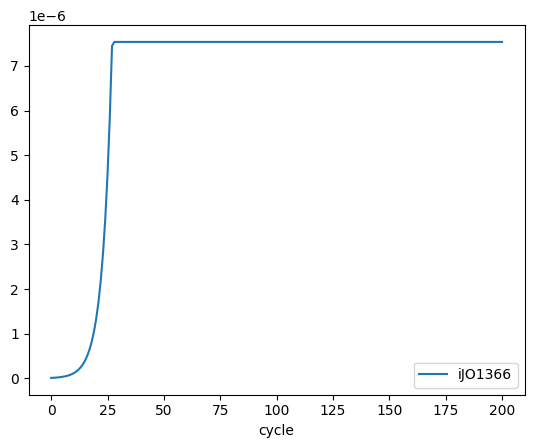

In [30]:
comp_assay.total_biomass.plot(x = "cycle")

## ESM

### Biomass, metabolites, fluxes

In [5]:
ESM_biomass = pd.DataFrame()
ESM_metabolites = pd.DataFrame()
ESM_biomass = pd.DataFrame()
ESM_fluxes = pd.DataFrame()
comparison = "plasmid"

E0_infected.reactions.plasmid_F.lower_bound = 0.0
E0_infected.reactions.phage_M13.lower_bound = 0.0
for i in np.arange(minimum_bound, maximum_bound_plasmid + 0.1, step_size_plasmid):
    E0_infected.objective = E0_infected.reactions.get_by_id("BIOMASS_Ec_iJO1366_core_53p95M")
    E0_infected.reactions.plasmid_F.lower_bound = i

    E_infected = c.model(E0_infected)
    S = c.model(S0)
    M = c.model(M0)
    E_infected.open_exchanges()
    S.open_exchanges()
    M.open_exchanges()

    E_infected.initial_pop = [0, 0, 1.e-8]
    S.initial_pop = [0, 0, 1.e-8]
    M.initial_pop = [0, 0, 1.e-8]
    E_infected.obj_style = "MAXIMIZE_OBJECTIVE_FLUX" #this is for pFBA - MAX_OBJECTIVE_FLUX for fba
    S.obj_style =  "MAXIMIZE_OBJECTIVE_FLUX"
    M.obj_style =  "MAXIMIZE_OBJECTIVE_FLUX"

    l = c.layout([E_infected,S,M])
    base_nutrients = ["ca2_e", "cl_e", "cobalt2_e", "cu2_e","fe2_e", "fe3_e", "k_e","mg2_e",
              "mn2_e", "mobd_e", "ni2_e", "o2_e", "pi_e", "so4_e", "zn2_e"]
    for nutrient in base_nutrients:
        l.set_specific_metabolite(nutrient, 1000)
    l.set_specific_metabolite("lcts_e", 0.000278)
    l.set_specific_metabolite("mea_e", 10)
    l.set_specific_metabolite("met__L_e", 0.000000015)

    p = c.params()
    p.set_param("defaultKm", 0.00001) # M 
    p.set_param("defaultVmax", 10) #mmol/gDw/hr
    p.set_param("maxCycles", 200)
    p.set_param("timeStep", 1)
    p.set_param("writeMediaLog", True)
    p.set_param("MediaLogRate", 1)
    p.set_param("writeFluxLog", True)
    p.set_param("FluxLogRate", 1)
    
    sim = c.comets(l, p)
    sim.run()
    
    temp = sim.total_biomass
    temp["lower_bound"] = i
    temp["optimized"] = comparison
    ESM_biomass = pd.concat([ESM_biomass, temp])

    temp1 = sim.get_metabolite_time_series()
    temp1["lower_bound"] = i
    temp1["optimized"] = comparison
    ESM_metabolites = pd.concat([ESM_metabolites, temp1])

    temp2 = sim.fluxes_by_species["iJO1366"]
    temp2["species"] = "iJO1366"
    temp2["lower_bound"] = i
    temp2["optimized"] = comparison
    temp3 = sim.fluxes_by_species["Mrubrum_AM1_hprKO"]
    temp3["species"] = "Mrubrum_AM1_hprKO"
    temp3["lower_bound"] = i
    temp3["optimized"] = comparison
    temp4 = sim.fluxes_by_species["STM_v1_0"]
    temp4["species"] = "STM_v1_0"
    temp4["lower_bound"] = i
    temp4["optimized"] = comparison
    ESM_fluxes = pd.concat([ESM_fluxes, temp2, temp3, temp4])


Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!


In [6]:
comparison = "virus with plasmid"
E0_infected.reactions.plasmid_F.lower_bound = 0.0
E0_infected.reactions.phage_M13.lower_bound = 0.0
for i in np.arange(minimum_bound, maximum_bound_phageplasmid + 0.001, step_size_phageplasmid):
    E0_infected.objective = E0_infected.reactions.get_by_id("BIOMASS_Ec_iJO1366_core_53p95M")
    E0_infected.reactions.phage_M13.lower_bound = i
    E0_infected.reactions.plasmid_F.lower_bound = plasmid_threshold

    E_infected = c.model(E0_infected)
    S = c.model(S0)
    M = c.model(M0)
    E_infected.open_exchanges()
    S.open_exchanges()
    M.open_exchanges()

    E_infected.initial_pop = [0, 0, 1.e-8]
    S.initial_pop = [0, 0, 1.e-8]
    M.initial_pop = [0, 0, 1.e-8]
    E_infected.obj_style = "MAXIMIZE_OBJECTIVE_FLUX" #this is for pFBA - MAX_OBJECTIVE_FLUX for fba
    S.obj_style =  "MAXIMIZE_OBJECTIVE_FLUX"
    M.obj_style =  "MAXIMIZE_OBJECTIVE_FLUX"

    l = c.layout([E_infected,S,M])
    base_nutrients = ["ca2_e", "cl_e", "cobalt2_e", "cu2_e","fe2_e", "fe3_e", "k_e","mg2_e",
              "mn2_e", "mobd_e", "ni2_e", "o2_e", "pi_e", "so4_e", "zn2_e"]
    for nutrient in base_nutrients:
        l.set_specific_metabolite(nutrient, 1000)
    l.set_specific_metabolite("lcts_e", 0.000278)
    l.set_specific_metabolite("mea_e", 10)
    l.set_specific_metabolite("met__L_e", 0.000000015)

    p = c.params()
    p.set_param("defaultKm", 0.00001) # M 
    p.set_param("defaultVmax", 10) #mmol/gDw/hr
    p.set_param("maxCycles", 200)
    p.set_param("timeStep", 1)
    p.set_param("writeMediaLog", True)
    p.set_param("MediaLogRate", 1)
    p.set_param("writeFluxLog", True)
    p.set_param("FluxLogRate", 1)
    
    sim = c.comets(l, p)
    sim.run()
    
    temp = sim.total_biomass
    temp["lower_bound"] = i
    temp["optimized"] = comparison
    ESM_biomass = pd.concat([ESM_biomass, temp])

    temp1 = sim.get_metabolite_time_series()
    temp1["lower_bound"] = i
    temp1["optimized"] = comparison
    ESM_metabolites = pd.concat([ESM_metabolites, temp1])

    temp2 = sim.fluxes_by_species["iJO1366"]
    temp2["species"] = "iJO1366"
    temp2["lower_bound"] = i
    temp2["optimized"] = comparison
    temp3 = sim.fluxes_by_species["Mrubrum_AM1_hprKO"]
    temp3["species"] = "Mrubrum_AM1_hprKO"
    temp3["lower_bound"] = i
    temp3["optimized"] = comparison
    temp4 = sim.fluxes_by_species["STM_v1_0"]
    temp4["species"] = "STM_v1_0"
    temp4["lower_bound"] = i
    temp4["optimized"] = comparison
    ESM_fluxes = pd.concat([ESM_fluxes, temp2, temp3, temp4])


Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!


In [7]:
ESM_biomass.to_csv(export_path_co + 'ESM_biomass_range.csv')
ESM_metabolites.to_csv(export_path_co + 'ESM_metabolites_range.csv')
ESM_fluxes.to_csv(export_path_co + 'ESM_fluxes_range.csv')

## ES

### Biomass, metabolites, fluxes

In [14]:
ES_biomass = pd.DataFrame()
ES_metabolites = pd.DataFrame()
ES_biomass = pd.DataFrame()
ES_fluxes = pd.DataFrame()
comparison = "plasmid"

E0_infected.reactions.plasmid_F.lower_bound = 0.0
E0_infected.reactions.phage_M13.lower_bound = 0.0
for i in np.arange(minimum_bound, maximum_bound_plasmid + 0.1, step_size_plasmid):
    E0_infected.objective = E0_infected.reactions.get_by_id("BIOMASS_Ec_iJO1366_core_53p95M")
    E0_infected.reactions.plasmid_F.lower_bound = i

    E_infected = c.model(E0_infected)
    S = c.model(S0)
    E_infected.open_exchanges()
    S.open_exchanges()

    E_infected.initial_pop = [0, 0, 1.e-8]
    S.initial_pop = [0, 0, 1.e-8]
    E_infected.obj_style = "MAXIMIZE_OBJECTIVE_FLUX"
    S.obj_style =  "MAXIMIZE_OBJECTIVE_FLUX"

    l = c.layout([E_infected,S])
    base_nutrients = ["ca2_e", "cl_e", "cobalt2_e", "cu2_e","fe2_e", "fe3_e", "k_e","mg2_e",
              "mn2_e", "mobd_e", "ni2_e", "o2_e", "nh4_e", "pi_e", "so4_e", "zn2_e"]
    for nutrient in base_nutrients:
        l.set_specific_metabolite(nutrient, 1000)
    l.set_specific_metabolite("lcts_e", 0.000278)
    l.set_specific_metabolite("met__L_e", 0.000000015)

    p = c.params()
    p.set_param("defaultKm", 0.00001) # M 
    p.set_param("defaultVmax", 10) #mmol/gDw/hr
    p.set_param("maxCycles", 200)
    p.set_param("timeStep", 1)
    p.set_param("writeMediaLog", True)
    p.set_param("MediaLogRate", 1)
    p.set_param("writeFluxLog", True)
    p.set_param("FluxLogRate", 1)
    
    sim = c.comets(l, p)
    sim.run()
    
    temp = sim.total_biomass
    temp["lower_bound"] = i
    temp["optimized"] = comparison
    ES_biomass = pd.concat([ES_biomass, temp])

    temp1 = sim.get_metabolite_time_series()
    temp1["lower_bound"] = i
    temp1["optimized"] = comparison
    ES_metabolites = pd.concat([ES_metabolites, temp1])

    temp2 = sim.fluxes_by_species["iJO1366"]
    temp2["species"] = "iJO1366"
    temp2["lower_bound"] = i
    temp2["optimized"] = comparison
    temp4 = sim.fluxes_by_species["STM_v1_0"]
    temp4["species"] = "STM_v1_0"
    temp4["lower_bound"] = i
    temp4["optimized"] = comparison
    ES_fluxes = pd.concat([ES_fluxes, temp2, temp4])


Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!


In [15]:
comparison = "virus with plasmid"

E0_infected.reactions.plasmid_F.lower_bound = 0.0
E0_infected.reactions.phage_M13.lower_bound = 0.0
for i in np.arange(minimum_bound, maximum_bound_phageplasmid + 0.003, step_size_phageplasmid):
    E0_infected.objective = E0_infected.reactions.get_by_id("BIOMASS_Ec_iJO1366_core_53p95M")
    E0_infected.reactions.phage_M13.lower_bound = i
    E0_infected.reactions.plasmid_F.lower_bound = plasmid_threshold

    E_infected = c.model(E0_infected)
    S = c.model(S0)
    E_infected.open_exchanges()
    S.open_exchanges()

    E_infected.initial_pop = [0, 0, 1.e-8]
    S.initial_pop = [0, 0, 1.e-8]
    E_infected.obj_style = "MAXIMIZE_OBJECTIVE_FLUX"
    S.obj_style =  "MAXIMIZE_OBJECTIVE_FLUX"

    l = c.layout([E_infected,S])
    base_nutrients = ["ca2_e", "cl_e", "cobalt2_e", "cu2_e","fe2_e", "fe3_e", "k_e","mg2_e",
              "mn2_e", "mobd_e", "ni2_e", "o2_e", "nh4_e", "pi_e", "so4_e", "zn2_e"]
    for nutrient in base_nutrients:
        l.set_specific_metabolite(nutrient, 1000)
    l.set_specific_metabolite("lcts_e", 0.000278)
    l.set_specific_metabolite("met__L_e", 0.000000015)

    p = c.params()
    p.set_param("defaultKm", 0.00001) # M 
    p.set_param("defaultVmax", 10) #mmol/gDw/hr
    p.set_param("maxCycles", 200)
    p.set_param("timeStep", 1)
    p.set_param("writeMediaLog", True)
    p.set_param("MediaLogRate", 1)
    p.set_param("writeFluxLog", True)
    p.set_param("FluxLogRate", 1)
    
    sim = c.comets(l, p)
    sim.run()
    
    temp = sim.total_biomass
    temp["lower_bound"] = i
    temp["optimized"] = comparison
    ES_biomass = pd.concat([ES_biomass, temp])

    temp1 = sim.get_metabolite_time_series()
    temp1["lower_bound"] = i
    temp1["optimized"] = comparison
    ES_metabolites = pd.concat([ES_metabolites, temp1])

    temp2 = sim.fluxes_by_species["iJO1366"]
    temp2["species"] = "iJO1366"
    temp2["lower_bound"] = i
    temp2["optimized"] = comparison
    temp4 = sim.fluxes_by_species["STM_v1_0"]
    temp4["species"] = "STM_v1_0"
    temp4["lower_bound"] = i
    temp4["optimized"] = comparison
    ES_fluxes = pd.concat([ES_fluxes, temp2, temp4])


Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!


In [16]:
ES_biomass.to_csv(export_path_co + 'ES_biomass_range.csv')
ES_metabolites.to_csv(export_path_co + 'ES_metabolites_range.csv')
ES_fluxes.to_csv(export_path_co + 'ES_fluxes_range.csv')

## EM

### Biomass, fluxes, metabolites

In [17]:
EM_biomass = pd.DataFrame()
EM_metabolites = pd.DataFrame()
EM_biomass = pd.DataFrame()
EM_fluxes = pd.DataFrame()
comparison = "plasmid"

E0_infected.reactions.plasmid_F.lower_bound = 0.0
E0_infected.reactions.phage_M13.lower_bound = 0.0
for i in np.arange(minimum_bound, maximum_bound_plasmid + 0.1, step_size_plasmid):
    E0_infected.objective = E0_infected.reactions.get_by_id("BIOMASS_Ec_iJO1366_core_53p95M")
    E0_infected.reactions.plasmid_F.lower_bound = i

    E_infected = c.model(E0_infected)
    M = c.model(M0)
    E_infected.open_exchanges()
    M.open_exchanges()

    E_infected.initial_pop = [0, 0, 1.e-8]
    M.initial_pop = [0, 0, 1.e-8]
    E_infected.obj_style = "MAXIMIZE_OBJECTIVE_FLUX"
    M.obj_style =  "MAXIMIZE_OBJECTIVE_FLUX"

    l = c.layout([E_infected,M])
    base_nutrients = ["ca2_e", "cl_e", "cobalt2_e", "cu2_e","fe2_e", "fe3_e", "k_e","mg2_e",
                  "mn2_e", "mobd_e", "ni2_e", "o2_e", "pi_e", "so4_e", "zn2_e"]
    for nutrient in base_nutrients:
        l.set_specific_metabolite(nutrient, 1000)
    l.set_specific_metabolite("lcts_e", 0.000278)
    l.set_specific_metabolite("mea_e", 10)
    l.set_specific_metabolite("met__L_e", 10)

    p = c.params()
    p.set_param("defaultKm", 0.00001) # M 
    p.set_param("defaultVmax", 10) #mmol/gDw/hr
    p.set_param("maxCycles", 200)
    p.set_param("timeStep", 1)
    p.set_param("writeMediaLog", True)
    p.set_param("MediaLogRate", 1)
    p.set_param("writeFluxLog", True)
    p.set_param("FluxLogRate", 1)

    sim = c.comets(l, p)
    sim.run()
    
    temp = sim.total_biomass
    temp["lower_bound"] = i
    temp["optimized"] = comparison
    EM_biomass = pd.concat([EM_biomass, temp])

    temp1 = sim.get_metabolite_time_series()
    temp1["lower_bound"] = i
    temp1["optimized"] = comparison
    EM_metabolites = pd.concat([EM_metabolites, temp1])

    temp2 = sim.fluxes_by_species["iJO1366"]
    temp2["species"] = "iJO1366"
    temp2["lower_bound"] = i
    temp2["optimized"] = comparison
    temp3 = sim.fluxes_by_species["Mrubrum_AM1_hprKO"]
    temp3["species"] = "Mrubrum_AM1_hprKO"
    temp3["lower_bound"] = i
    temp3["optimized"] = comparison
    EM_fluxes = pd.concat([EM_fluxes, temp2, temp3])


Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!


In [18]:
comparison = "virus with plasmid"

E0_infected.reactions.plasmid_F.lower_bound = 0.0
E0_infected.reactions.phage_M13.lower_bound = 0.0
for i in np.arange(minimum_bound, maximum_bound_phageplasmid + 0.003, step_size_phageplasmid):
    E0_infected.objective = E0_infected.reactions.get_by_id("BIOMASS_Ec_iJO1366_core_53p95M")
    E0_infected.reactions.phage_M13.lower_bound = i
    E0_infected.reactions.plasmid_F.lower_bound = plasmid_threshold

    E_infected = c.model(E0_infected)
    M = c.model(M0)
    E_infected.open_exchanges()
    M.open_exchanges()

    E_infected.initial_pop = [0, 0, 1.e-8]
    M.initial_pop = [0, 0, 1.e-8]
    E_infected.obj_style = "MAXIMIZE_OBJECTIVE_FLUX"
    M.obj_style =  "MAXIMIZE_OBJECTIVE_FLUX"

    l = c.layout([E_infected,M])
    base_nutrients = ["ca2_e", "cl_e", "cobalt2_e", "cu2_e","fe2_e", "fe3_e", "k_e","mg2_e",
                  "mn2_e", "mobd_e", "ni2_e", "o2_e", "pi_e", "so4_e", "zn2_e"]
    for nutrient in base_nutrients:
        l.set_specific_metabolite(nutrient, 1000)
    l.set_specific_metabolite("lcts_e", 0.000278)
    l.set_specific_metabolite("mea_e", 10)
    l.set_specific_metabolite("met__L_e", 10)

    p = c.params()
    p.set_param("defaultKm", 0.00001) # M 
    p.set_param("defaultVmax", 10) #mmol/gDw/hr
    p.set_param("maxCycles", 200)
    p.set_param("timeStep", 1)
    p.set_param("writeMediaLog", True)
    p.set_param("MediaLogRate", 1)
    p.set_param("writeFluxLog", True)
    p.set_param("FluxLogRate", 1)

    sim = c.comets(l, p)
    sim.run()
    
    temp = sim.total_biomass
    temp["lower_bound"] = i
    temp["optimized"] = comparison
    EM_biomass = pd.concat([EM_biomass, temp])

    temp1 = sim.get_metabolite_time_series()
    temp1["lower_bound"] = i
    temp1["optimized"] = comparison
    EM_metabolites = pd.concat([EM_metabolites, temp1])

    temp2 = sim.fluxes_by_species["iJO1366"]
    temp2["species"] = "iJO1366"
    temp2["lower_bound"] = i
    temp2["optimized"] = comparison
    temp3 = sim.fluxes_by_species["Mrubrum_AM1_hprKO"]
    temp3["species"] = "Mrubrum_AM1_hprKO"
    temp3["lower_bound"] = i
    temp3["optimized"] = comparison
    EM_fluxes = pd.concat([EM_fluxes, temp2, temp3])


Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!

Running COMETS simulation ...

Debug Here ...
Done!


In [19]:
EM_biomass.to_csv(export_path_co + 'EM_biomass_range.csv')
EM_metabolites.to_csv(export_path_co + 'EM_metabolites_range.csv')
EM_fluxes.to_csv(export_path_co + 'EM_fluxes_range.csv')

## E

### Biomass, metabolites, fluxes

In [22]:
E_biomass = pd.DataFrame()
E_metabolites = pd.DataFrame()
E_biomass = pd.DataFrame()
E_fluxes = pd.DataFrame()
comparison = "plasmid"

E0_infected.reactions.plasmid_F.lower_bound = 0.0
E0_infected.reactions.phage_M13.lower_bound = 0.0
for i in np.arange(minimum_bound, maximum_bound_plasmid + 0.1, step_size_plasmid):
    E0_infected.objective = E0_infected.reactions.get_by_id("BIOMASS_Ec_iJO1366_core_53p95M")
    E0_infected.reactions.plasmid_F.lower_bound = i

    E_infected = c.model(E0_infected)
    E_infected.open_exchanges()

    E_infected.initial_pop = [0, 0, 1.e-8]
    E_infected.obj_style = "MAXIMIZE_OBJECTIVE_FLUX"

    test_tube = c.layout()
    test_tube.add_model(E_infected)

    base_nutrients = ['ca2_e', 'cl_e', 'cobalt2_e', 'cu2_e', 'fe2_e', 'fe3_e', 'h_e', 'k_e', 'h2o_e', 'mg2_e',
                 'mn2_e', 'mobd_e', 'na1_e', 'ni2_e', 'nh4_e', 'o2_e', 'pi_e', 'so4_e', 'zn2_e']
    for nutrient in base_nutrients:
        test_tube.set_specific_metabolite(nutrient, 1000)
        test_tube.set_specific_static(nutrient, 1000)
    test_tube.set_specific_metabolite("lcts_e", 0.000278)
    test_tube.set_specific_metabolite('met__L_e', 10)

    sim_params = c.params()
    sim_params.set_param("defaultKm", 0.00001) # M 
    sim_params.set_param("defaultVmax", 10) #mmol/gDw/hr
    sim_params.set_param("maxCycles", 200)
    sim_params.set_param("timeStep", 1)
    sim_params.set_param("writeMediaLog", True)
    sim_params.set_param("MediaLogRate", 1)
    sim_params.set_param("writeFluxLog", True)
    sim_params.set_param("FluxLogRate", 1)

    comp_assay = c.comets(test_tube, sim_params)
    comp_assay.run()

    temp = comp_assay.total_biomass
    temp["lower_bound"] = i
    temp["optimized"] = comparison
    E_biomass = pd.concat([E_biomass, temp])

    temp1 = comp_assay.get_metabolite_time_series()
    temp1["lower_bound"] = i
    temp1["optimized"] = comparison
    E_metabolites = pd.concat([E_metabolites, temp1])

    temp2 = comp_assay.fluxes_by_species["iJO1366"]
    temp2["species"] = "iJO1366"
    temp2["lower_bound"] = i
    temp2["optimized"] = comparison
    E_fluxes = pd.concat([E_fluxes, temp2])

building empty layout model
models will need to be added with layout.add_model()

Running COMETS simulation ...

Debug Here ...
Done!
building empty layout model
models will need to be added with layout.add_model()

Running COMETS simulation ...

Debug Here ...
Done!
building empty layout model
models will need to be added with layout.add_model()

Running COMETS simulation ...

Debug Here ...
Done!
building empty layout model
models will need to be added with layout.add_model()

Running COMETS simulation ...

Debug Here ...
Done!
building empty layout model
models will need to be added with layout.add_model()

Running COMETS simulation ...

Debug Here ...
Done!
building empty layout model
models will need to be added with layout.add_model()

Running COMETS simulation ...

Debug Here ...
Done!
building empty layout model
models will need to be added with layout.add_model()

Running COMETS simulation ...

Debug Here ...
Done!
building empty layout model
models will need to be added with 

In [23]:
#phage and plasmid
comparison = "virus with plasmid"

E0_infected.reactions.plasmid_F.lower_bound = 0.0
E0_infected.reactions.phage_M13.lower_bound = 0.0
for i in np.arange(minimum_bound, maximum_bound_phageplasmid + 0.003, step_size_phageplasmid):
    E0_infected.objective = E0_infected.reactions.get_by_id("BIOMASS_Ec_iJO1366_core_53p95M")
    E0_infected.reactions.phage_M13.lower_bound = i
    E0_infected.reactions.plasmid_F.lower_bound = plasmid_threshold

    E_infected = c.model(E0_infected)
    E_infected.open_exchanges()

    E_infected.initial_pop = [0, 0, 1.e-8]
    E_infected.obj_style = "MAXIMIZE_OBJECTIVE_FLUX"

    test_tube = c.layout()
    test_tube.add_model(E_infected)

    base_nutrients = ['ca2_e', 'cl_e', 'cobalt2_e', 'cu2_e', 'fe2_e', 'fe3_e', 'h_e', 'k_e', 'h2o_e', 'mg2_e',
                 'mn2_e', 'mobd_e', 'na1_e', 'ni2_e', 'nh4_e', 'o2_e', 'pi_e', 'so4_e', 'zn2_e']
    for nutrient in base_nutrients:
        test_tube.set_specific_metabolite(nutrient, 1000)
        test_tube.set_specific_static(nutrient, 1000)
    test_tube.set_specific_metabolite("lcts_e", 0.000278)
    test_tube.set_specific_metabolite('met__L_e', 10)

    sim_params = c.params()
    sim_params.set_param("defaultKm", 0.00001) # M 
    sim_params.set_param("defaultVmax", 10) #mmol/gDw/hr
    sim_params.set_param("maxCycles", 200)
    sim_params.set_param("timeStep", 1)
    sim_params.set_param("writeMediaLog", True)
    sim_params.set_param("MediaLogRate", 1)
    sim_params.set_param("writeFluxLog", True)
    sim_params.set_param("FluxLogRate", 1)

    comp_assay = c.comets(test_tube, sim_params)
    comp_assay.run()

    temp = comp_assay.total_biomass
    temp["lower_bound"] = i
    temp["optimized"] = comparison
    E_biomass = pd.concat([E_biomass, temp])

    temp1 = comp_assay.get_metabolite_time_series()
    temp1["lower_bound"] = i
    temp1["optimized"] = comparison
    E_metabolites = pd.concat([E_metabolites, temp1])

    temp2 = comp_assay.fluxes_by_species["iJO1366"]
    temp2["species"] = "iJO1366"
    temp2["lower_bound"] = i
    temp2["optimized"] = comparison
    E_fluxes = pd.concat([E_fluxes, temp2])

building empty layout model
models will need to be added with layout.add_model()

Running COMETS simulation ...

Debug Here ...
Done!
building empty layout model
models will need to be added with layout.add_model()

Running COMETS simulation ...

Debug Here ...
Done!
building empty layout model
models will need to be added with layout.add_model()

Running COMETS simulation ...

Debug Here ...
Done!
building empty layout model
models will need to be added with layout.add_model()

Running COMETS simulation ...

Debug Here ...
Done!
building empty layout model
models will need to be added with layout.add_model()

Running COMETS simulation ...

Debug Here ...
Done!
building empty layout model
models will need to be added with layout.add_model()

Running COMETS simulation ...

Debug Here ...
Done!
building empty layout model
models will need to be added with layout.add_model()

Running COMETS simulation ...

Debug Here ...
Done!
building empty layout model
models will need to be added with 

In [24]:
E_biomass.to_csv(export_path_E + 'E_biomass_range.csv')
E_metabolites.to_csv(export_path_E + 'E_metabolites_range.csv')
E_fluxes.to_csv(export_path_E + 'E_fluxes_range.csv')